In [16]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import model as dl
import joblib
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def test(i, loader, neural_network):
    acc = 0
    results_sum = []
    labels_test_sum = []
    results_PR_sum = []
    for step, (data, labels) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device)
        # 前向传播
        outputs = neural_network(data.float())
        acc += outputs.argmax(dim=1).eq(labels).type_as(torch.FloatTensor()).mean()
        results_sum = np.append(results_sum, outputs.argmax(dim=1).cpu().numpy())
        labels_test_sum = np.append(labels_test_sum, labels.cpu().numpy())
        results_PR_sum.extend(outputs.detach().cpu().numpy())
    acc_average = acc / (step + 1)
    print("第" + str(i + 1) + "次训练测试集准确率: {:.4f}".format(acc_average))
    return acc_average, results_sum, labels_test_sum, results_PR_sum

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    # 定义一种字体属性
    font1 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 20}
    font2 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 18}
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(num=None, figsize=(6, 6), dpi=60)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict=font1, y=1.05)
    plt.colorbar(shrink=0.64)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontdict=font2)
    plt.yticks(tick_marks, classes, rotation=45, fontdict=font2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                verticalalignment="center",
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontdict=font2)
    plt.tight_layout()
    plt.ylabel('Actual Class', fontdict=font2)
    plt.xlabel('Predict Class', fontdict=font2)
    plt.subplots_adjust(left=0.2, top=1.02, bottom=0.05)
    plt.show()

In [19]:
name = locals()
seed = 22
dl.seed_everything(seed)
model_type = 'STCGRU'
batch_size = 256
total_fold = 10  # 10折

test_acc_sum = 0
results_sum = []
labels_test_sum = []
results_PR_sum = []
srate = "64"
for i in range(total_fold):
    test_data_combine = torch.load("EEGData/"+srate+"hz/TestData/test_data_"+ str(i + 1) + "_fold_with_seed_" + str(seed) + ".pth", weights_only=False)
    test_loader = DataLoader(dataset=test_data_combine,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=8)

    model = dl.STCGRU().to(device)
    model_loc =  "stcgru/"+srate+"hz/"+str(i + 1) + "_fold_model_parameter_with_seed_" + str(seed) + ".pth"
    model_dict = torch.load(model_loc)
    model.load_state_dict(model_dict)
    '''测试'''
    acc_average, results, labels_test, results_PR = test(i, loader=test_loader, neural_network=model)
    results_sum = np.append(results_sum, results)
    labels_test_sum = np.append(labels_test_sum, labels_test)
    results_PR_sum.extend(results_PR)
    name['test_acc_average_' + str(i + 1)] = acc_average
    confusion_matrix_single = confusion_matrix(labels_test, results, labels=[0, 1])
    kappa_single = cohen_kappa_score(labels_test, results)
    sensitivity_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[0, 1])  # 灵敏度（召回率）
    specificity_single = confusion_matrix_single[1, 1] / (confusion_matrix_single[1, 1] + confusion_matrix_single[1, 0])  # 特异度
    precision_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[1, 0])  # 查准率
    F1_single = 2 * precision_single * sensitivity_single / (precision_single + sensitivity_single)  # F1值
    print(model_type + " 第%d折交叉验证测试集准确率: %.4f，kappa值：%.4f，灵敏度：%.4f，特异度：%.4f，查准率：%.4f，F1值：%.4f"
        % (i+1, acc_average, kappa_single, sensitivity_single, specificity_single, precision_single, F1_single))
for i in range(total_fold):
    if i == 0:
        test_acc_sum = name['test_acc_average_' + str(i + 1)]
    else:
        test_acc_sum = np.append(test_acc_sum, name['test_acc_average_' + str(i + 1)])
    del name['test_acc_average_' + str(i + 1)]

/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第1次训练测试集准确率: 0.8707
STCGRU 第1折交叉验证测试集准确率: 0.8707，kappa值：0.7802，灵敏度：0.8386，特异度：0.9357，查准率：0.9142，F1值：0.8747


/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第2次训练测试集准确率: 0.8781
STCGRU 第2折交叉验证测试集准确率: 0.8781，kappa值：0.7726，灵敏度：0.8300，特异度：0.9359，查准率：0.9130，F1值：0.8696


/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第3次训练测试集准确率: 0.8982
STCGRU 第3折交叉验证测试集准确率: 0.8982，kappa值：0.7891，灵敏度：0.8479，特异度：0.9371，查准率：0.9215，F1值：0.8832


/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第4次训练测试集准确率: 0.8834
STCGRU 第4折交叉验证测试集准确率: 0.8834，kappa值：0.7577，灵敏度：0.8491，特异度：0.9066，查准率：0.8640，F1值：0.8565


/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第5次训练测试集准确率: 0.8397
STCGRU 第5折交叉验证测试集准确率: 0.8397，kappa值：0.7230，灵敏度：0.8107，特异度：0.9065，查准率：0.8678，F1值：0.8383


/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第6次训练测试集准确率: 0.8417
STCGRU 第6折交叉验证测试集准确率: 0.8417，kappa值：0.6478，灵敏度：0.8230，特异度：0.8287，查准率：0.7843，F1值：0.8032


/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第7次训练测试集准确率: 0.8522
STCGRU 第7折交叉验证测试集准确率: 0.8522，kappa值：0.6792，灵敏度：0.7591，特异度：0.9172，查准率：0.8966，F1值：0.8221


/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第8次训练测试集准确率: 0.8795
STCGRU 第8折交叉验证测试集准确率: 0.8795，kappa值：0.7536，灵敏度：0.8784，特异度：0.8770，查准率：0.8550，F1值：0.8665


/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第9次训练测试集准确率: 0.7738
STCGRU 第9折交叉验证测试集准确率: 0.7738，kappa值：0.6125，灵敏度：0.6353，特异度：0.9664，查准率：0.9441，F1值：0.7596


/tmp/ipykernel_289126/3655220913.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_loc)


第10次训练测试集准确率: 0.8616
STCGRU 第10折交叉验证测试集准确率: 0.8616，kappa值：0.7438，灵敏度：0.7643，特异度：0.9701，查准率：0.9571，F1值：0.8499


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Confusion matrix, without normalization
[[2042  504]
 [ 256 2841]]


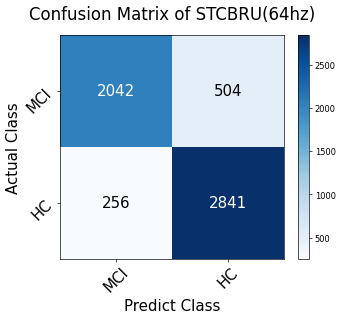

STCGRU 10折交叉验证平均测试集准确率: 0.8579 ± 0.0332，kappa值：0.7257，灵敏度：0.8020，特异度：0.9173，查准率：0.8886，F1值：0.8431


In [20]:
test_acc_final = np.sum(test_acc_sum) / total_fold
test_acc_std = float(np.std(test_acc_sum))
confusion_matrix = confusion_matrix(labels_test_sum, results_sum, labels=[0, 1])

kappa = cohen_kappa_score(labels_test_sum, results_sum)
sensitivity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])  # 灵敏度（召回率）
specificity = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])  # 特异度
precision = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[1, 0])  # 查准率
F1 = 2 * precision * sensitivity / (precision + sensitivity)  # F1值
plot_confusion_matrix(confusion_matrix, classes=['MCI', 'HC'], normalize=False,
                    title='Confusion Matrix of STCBRU('+srate+'hz)')

print(model_type + " %d折交叉验证平均测试集准确率: %.4f ± %.4f，kappa值：%.4f，灵敏度：%.4f，特异度：%.4f，查准率：%.4f，F1值：%.4f"
    % (total_fold, test_acc_final, test_acc_std, kappa, sensitivity, specificity, precision, F1))
